# **Issues & Solutions Summary**

## **🚨 Critical Issues Faced & Fixed**

### **1. CUDA Device Assert Error**

- **Issue**: Training crashed with "CUDA error: device-side assert triggered"
- **Root Cause**: Class indices in labels were `[1, 2, 3]` but YOLO expected `[0, 1, 2]`
- **Solution**: Created mapping script to convert `1→0, 2→1, 3→2` in all label files

### **2. Missing Validation Labels**

- **Issue**: "No labels found in validation set" - no metrics computed
- **Root Cause**: Validation folder only contained images, no labels directory
- **Solution**: Created validation labels directory and populated with corresponding annotations

### **3. Corrupted Dataset Files**

- **Issue**: 42 training files and 7 validation files marked as "corrupt" and ignored
- **Root Cause**: Class index mismatch (class 3 exceeded dataset class count of 3)
- **Solution**: Fixed class mapping - all files now processed successfully

### **4. Poor Mask Performance**

- **Issue**: Very high mAP50 (95.5%) but zero mask metrics. I did prediction on test, validation, and even on training data to see what is going on
- **Root Cause**: Segmentation head is broken, **NaN segmentation loss** during training, I realised my stupid decision of choosing segmentation version of YOLO for a problem that is obviously not suitable for segmentation.
- **Solution**:  changed to “yolo11m.pt” for object detection → everything was fixed. and the model was able to detect

## **📊 Results After Fixes**

- ✅ **Before**: 42 corrupt files → **After**: 0 corrupt files
- ✅ **Before**: No validation metrics → **After**: Full metrics computed
- ✅ **Before**: Segmentation training instability → **After**: Stable object detection training
- ✅ **Before**: Zero detections in inference → **After**: Working detection model
- ✅ **Before**: Broken mask metrics (0.000) → **After**: Excellent detection metrics

## **🎯 Final Object Detection Solution**

1. **Model Switch**: Successfully transitioned from segmentation to object detection approach
2. **Working Inference**: Model now detects oil spills correctly on test images
3. **Comprehensive Code Suite**: Complete prediction, evaluation, visualization, and testing code for object detection
4. **Deployment Ready**: Stable, working model suitable for production oil spill detection

In [1]:
%pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.9 MB/s eta 0:00:00


In [2]:
import os
from ultralytics import YOLO
import matplotlib.pyplot as plt

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from collections import Counter

def analyze_dataset():
    """Analyze dataset distribution and characteristics"""

    # Count images per split
    train_images = len(os.listdir('/content/drive/MyDrive/data/train/images/'))
    val_images = len(os.listdir('/content/drive/MyDrive/data/valid/images/'))
    test_images = len(os.listdir('/content/drive/MyDrive/data/test/images/'))

    print(f"Dataset Distribution:")
    print(f"Training images: {train_images}")
    print(f"Validation images: {val_images}")
    print(f"Test images: {test_images}")
    print(f"Total: {train_images + val_images + test_images}")

    # Analyze class distribution
    class_counts = Counter()
    label_files = os.listdir('/content/drive/MyDrive/data/train/labels/')

    for label_file in label_files:
        if label_file.endswith('.txt'):
            with open(f'/content/drive/MyDrive/data/train/labels/{label_file}', 'r') as f:
                for line in f:
                    if line.strip():
                        class_id = int(line.split()[0])
                        class_counts[class_id] += 1

    print(f"\nClass Distribution in Training Set:")
    class_names = ['object', 'rainbow', 'sheen', 'truecolor']
    for class_id, count in class_counts.items():
        print(f"{class_names[class_id]}: {count} instances")

    return class_counts

# Run analysis
class_distribution = analyze_dataset()

Dataset Distribution:
Training images: 1044
Validation images: 8
Test images: 90
Total: 1142

Class Distribution in Training Set:
object: 1 instances
sheen: 621 instances
rainbow: 281 instances
truecolor: 1158 instances


In [ ]:
import os
import glob
from collections import Counter

def analyze_class_distribution():
    """Analyze the actual class distribution in your dataset"""

    # Path to your training labels
    labels_dir = '/content/drive/MyDrive/data/train/labels/'

    if not os.path.exists(labels_dir):
        print(f"Labels directory not found: {labels_dir}")
        return

    # Get all label files
    label_files = glob.glob(os.path.join(labels_dir, "*.txt"))

    # Count classes
    class_counts = Counter()

    print(f"Analyzing {len(label_files)} label files...")

    for label_file in label_files:
        try:
            with open(label_file, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if parts:  # Skip empty lines
                        class_id = int(parts[0])
                        class_counts[class_id] += 1
        except Exception as e:
            print(f"Error reading {label_file}: {e}")

    # Display results
    print("\n📊 CLASS DISTRIBUTION ANALYSIS:")
    print("=" * 40)

    for class_id in sorted(class_counts.keys()):
        print(f"Class {class_id}: {class_counts[class_id]} instances")

    print(f"\nTotal annotations: {sum(class_counts.values())}")

    # Check what classes are expected vs actual
    expected_classes = [0, 1, 2]  # For nc=3
    actual_classes = list(class_counts.keys())

    print(f"\n🎯 EXPECTED vs ACTUAL:")
    print(f"Expected classes (0-indexed): {expected_classes}")
    print(f"Actual classes in data: {actual_classes}")

    missing_classes = set(expected_classes) - set(actual_classes)
    extra_classes = set(actual_classes) - set(expected_classes)

    if missing_classes:
        print(f"❌ Missing classes: {list(missing_classes)}")
    if extra_classes:
        print(f"⚠️  Extra classes (out of range): {list(extra_classes)}")

    return class_counts

# Run the analysis
analyze_class_distribution()

Analyzing 1044 label files...

📊 CLASS DISTRIBUTION ANALYSIS:
Class 0: 1 instances
Class 1: 281 instances
Class 2: 621 instances
Class 3: 1158 instances

Total annotations: 2061

🎯 EXPECTED vs ACTUAL:
Expected classes (0-indexed): [0, 1, 2]
Actual classes in data: [0, 2, 1, 3]
⚠️  Extra classes (out of range): [3]


Counter({0: 1, 2: 621, 1: 281, 3: 1158})

In [ ]:
import os
import glob

def map_classes_simple():
    """Simple class mapping: 1->0, 2->1, 3->2"""

    # Class mapping
    class_mapping = {1: 0, 2: 1, 3: 2}

    # Process all splits
    splits = ['train', 'test', 'valid']

    for split in splits:
        labels_dir = f'/content/drive/MyDrive/data/{split}/labels/'

        if not os.path.exists(labels_dir):
            print(f"❌ {split}: No labels directory")
            continue

        label_files = glob.glob(os.path.join(labels_dir, "*.txt"))
        print(f"🔄 {split}: Processing {len(label_files)} files...")

        fixed_count = 0

        for label_file in label_files:
            try:
                # Read file
                with open(label_file, 'r') as f:
                    lines = f.readlines()

                # Process lines
                new_lines = []
                changed = False

                for line in lines:
                    if line.strip():
                        parts = line.strip().split()
                        old_class = int(parts[0])

                        # Apply mapping
                        if old_class in class_mapping:
                            parts[0] = str(class_mapping[old_class])
                            changed = True

                        new_lines.append(' '.join(parts) + '\n')
                    else:
                        new_lines.append(line)

                # Write back if changed
                if changed:
                    with open(label_file, 'w') as f:
                        f.writelines(new_lines)
                    fixed_count += 1

            except Exception as e:
                print(f"Error: {label_file} - {e}")

        print(f"✅ {split}: Fixed {fixed_count} files")

    print("\n🎉 Mapping completed!")

# Run the mapping
map_classes_simple()

# Clear cache files
cache_files = [
    '/content/drive/MyDrive/data/train/labels.cache',
    '/content/drive/MyDrive/data/valid/labels.cache',
    '/content/drive/MyDrive/data/test/labels.cache'
]

for cache_file in cache_files:
    if os.path.exists(cache_file):
        os.remove(cache_file)
        print(f"🗑️ Removed {cache_file}")

print("✅ Done! Classes mapped: 1→0, 2→1, 3→2")

🔄 train: Processing 1044 files...
✅ train: Fixed 1016 files
🔄 test: Processing 90 files...
✅ test: Fixed 89 files
🔄 valid: Processing 8 files...
✅ valid: Fixed 8 files

🎉 Mapping completed!
✅ Done! Classes mapped: 1→0, 2→1, 3→2


In [24]:
model = YOLO("yolo11m.pt")
print("model loaded!")

model loaded!


In [ ]:
def setup_advanced_augmentations():
    """Configure advanced augmentations for satellite imagery"""
    return {
        # Geometric augmentations
        'degrees': 30.0,        
        'translate': 0.1,       
        'scale': 0.5,          
        'shear': 8.0,         
        'perspective': 0.0005,  

        # Flip augmentations
        'flipud': 0.5,         
        'fliplr': 0.5,         

        # Color augmentations 
        'hsv_h': 0.02,         
        'hsv_s': 0.3,          
        'hsv_v': 0.3,          

        # Advanced augmentations
        'mosaic': 0.5,         
        'mixup': 0.15,         
        'copy_paste': 0.1,     
        'erasing': 0.1,        
    }


In [27]:
aug_params = setup_advanced_augmentations()

result = model.train(
    data='data.yaml',
    epochs=150,
    imgsz=640,
    batch=32,
    seed=42,
    patience=0,
    cache=False,
    val=True,
    optimizer='AdamW',
    momentum= 0.937,
    lr0=0.01,
    lrf= 0.1,
    weight_decay=0.0005,
    save_period = 10,
    **aug_params,
    close_mosaic=10,
    )

Ultralytics 8.3.201 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=30.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.1, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.02, hsv_s=0.3, hsv_v=0.3, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.1, mask_ratio=4, max_det=300, mixup=0.15, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=0.5, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=0, perspective=0.0005, plots=True, pose=12.

In [28]:
best_model_path = '/content/drive/MyDrive/oil_spill_best_md_obj.pt'
model.save(best_model_path)

In [29]:
model = YOLO('/content/drive/MyDrive/oil_spill_best_md_obj.pt')

In [30]:
def evaluate_model():
    print("📊 Evaluating model performance...")

    # Run validation
    metrics = model.val()

    print("🎯 EVALUATION RESULTS:")
    print("=" * 50)

    # Overall metrics
    print(f"📈 Overall Performance:")
    print(f"   mAP50: {metrics.box.map50:.3f} ({metrics.box.map50:.1%})")
    print(f"   mAP50-95: {metrics.box.map:.3f} ({metrics.box.map:.1%})")
    print(f"   Precision: {metrics.box.mp:.3f} ({metrics.box.mp:.1%})")
    print(f"   Recall: {metrics.box.mr:.3f} ({metrics.box.mr:.1%})")

    # F1 Score
    if metrics.box.mp > 0 and metrics.box.mr > 0:
        f1 = 2 * (metrics.box.mp * metrics.box.mr) / (metrics.box.mp + metrics.box.mr)
        print(f"   F1 Score: {f1:.3f} ({f1:.1%})")

    # Per-class metrics if available
    class_names = ['rainbow', 'sheen', 'truecolor']

    if hasattr(metrics.box, 'ap_class_index') and metrics.box.ap_class_index is not None:
        print(f"\n📋 Per-Class Performance:")

        # Map class indices to names
        for i, class_idx in enumerate(metrics.box.ap_class_index):
            if i < len(metrics.box.ap50):
                class_name = class_names[int(class_idx)] if int(class_idx) < len(class_names) else f"Class {int(class_idx)}"
                print(f"   {class_name}:")
                print(f"      mAP50: {metrics.box.ap50[i]:.3f}")
                if i < len(metrics.box.ap):
                    print(f"      mAP50-95: {metrics.box.ap[i]:.3f}")

    # Performance interpretation
    print(f"\n🔍 PERFORMANCE INTERPRETATION:")
    if metrics.box.map50 > 0.7:
        print("✅ Excellent performance!")
    elif metrics.box.map50 > 0.5:
        print("🟢 Good performance")
    elif metrics.box.map50 > 0.3:
        print("🟡 Moderate performance - room for improvement")
    elif metrics.box.map50 > 0.1:
        print("🟠 Poor performance - needs improvement")
    else:
        print("🔴 Very poor performance - major improvements needed")

    return metrics

# Run evaluation
eval_metrics = evaluate_model()

📊 Evaluating model performance...
Ultralytics 8.3.201 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11m summary (fused): 125 layers, 20,032,345 parameters, 0 gradients, 67.7 GFLOPs
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 17.4±5.7 MB/s, size: 17.8 KB)
val: Scanning /content/drive/MyDrive/data/valid/labels.cache... 8 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 8/8 16.0Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 3.6it/s 0.3s
                   all          8         39      0.857      0.919      0.937      0.813
                 sheen          1          2      0.853          1      0.995      0.921
             truecolor          7         37      0.861      0.838      0.879      0.705
Speed: 0.2ms preprocess, 5.1ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to /content/runs/detect/val
🎯 EVALUATION RESULTS:
📈 Overall Performance:
   mAP5

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os
import glob
from collections import Counter

def predict_on_test_images():
    """Predict oil spills on all test images"""

    print("🔮 Predicting on test images...")

    # Get all test images
    test_images = glob.glob('/content/drive/MyDrive/data/test/images/*.jpg')

    print(f"📁 Found {len(test_images)} test images")

    
    results = model.predict(
        source='/content/drive/MyDrive/data/test/images/',
        conf=0.15,              
        iou=0.5,                
        save=True,              
        show_conf=True,         
        show_labels=True,       
        project='/content/runs/predict',
        name='test_predictions'
    )

    # Analyze results
    total_detections = 0
    images_with_detections = 0
    class_counts = Counter()
    confidence_scores = []

    class_names = ['rainbow', 'sheen', 'truecolor']

    for i, result in enumerate(results):
        if result.boxes is not None and len(result.boxes) > 0:
            images_with_detections += 1

            for box in result.boxes:
                total_detections += 1
                class_id = int(box.cls.item())
                conf = box.conf.item()

                class_counts[class_names[class_id]] += 1
                confidence_scores.append(conf)

    # Print summary
    print(f"\n📊 PREDICTION SUMMARY:")
    print("=" * 40)
    print(f"Images processed: {len(test_images)}")
    print(f"Images with detections: {images_with_detections}")
    print(f"Total detections: {total_detections}")
    print(f"Detection rate: {images_with_detections/len(test_images):.1%}")

    if confidence_scores:
        print(f"Average confidence: {sum(confidence_scores)/len(confidence_scores):.3f}")

    print(f"\n🎯 CLASS DISTRIBUTION:")
    for class_name, count in class_counts.items():
        percentage = (count / total_detections * 100) if total_detections > 0 else 0
        print(f"• {class_name}: {count} detections ({percentage:.1f}%)")

    # Show sample results
    print(f"\n🖼️ Results saved to: /content/runs/predict/test_predictions/")

    return results

# Run predictions
test_results = predict_on_test_images()

🔮 Predicting on test images...
📁 Found 90 test images

image 1/90 /content/drive/MyDrive/data/test/images/1-1-_jpg.rf.5a912e14024546795e40f8f6c85d3c2a.jpg: 640x640 2 sheens, 11.8ms
image 2/90 /content/drive/MyDrive/data/test/images/1-1-_jpg.rf.98455e18425d74558ce0822c649ae90a.jpg: 640x640 2 sheens, 10.9ms
image 3/90 /content/drive/MyDrive/data/test/images/1-10-_jpg.rf.1c9a6303f0afc4a5c89429f3f85751fa.jpg: 640x640 2 truecolors, 10.7ms
image 4/90 /content/drive/MyDrive/data/test/images/1-10-_jpg.rf.2c724f80fa5ed1ad5b7fd119ab7f3c37.jpg: 640x640 2 truecolors, 10.5ms
image 5/90 /content/drive/MyDrive/data/test/images/1-10-_jpg.rf.67374d33658ec240e91d290e005fb25b.jpg: 640x640 2 truecolors, 10.5ms
image 6/90 /content/drive/MyDrive/data/test/images/1-5-_jpg.rf.10361347027b572c29df817886c1ea74.jpg: 640x640 3 sheens, 10.5ms
image 7/90 /content/drive/MyDrive/data/test/images/1-5-_jpg.rf.86b3402043df67b9fed6aa86fd02e4bb.jpg: 640x640 2 sheens, 10.5ms
image 8/90 /content/drive/MyDrive/data/test/imag

🎨 Visualizing 6 sample results...

0: 640x640 5 truecolors, 14.6ms
1: 640x640 3 truecolors, 14.6ms
2: 640x640 1 sheen, 14.6ms
3: 640x640 2 sheens, 1 truecolor, 14.6ms
4: 640x640 4 truecolors, 14.6ms
5: 640x640 1 rainbow, 1 truecolor, 14.6ms
Speed: 2.1ms preprocess, 14.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


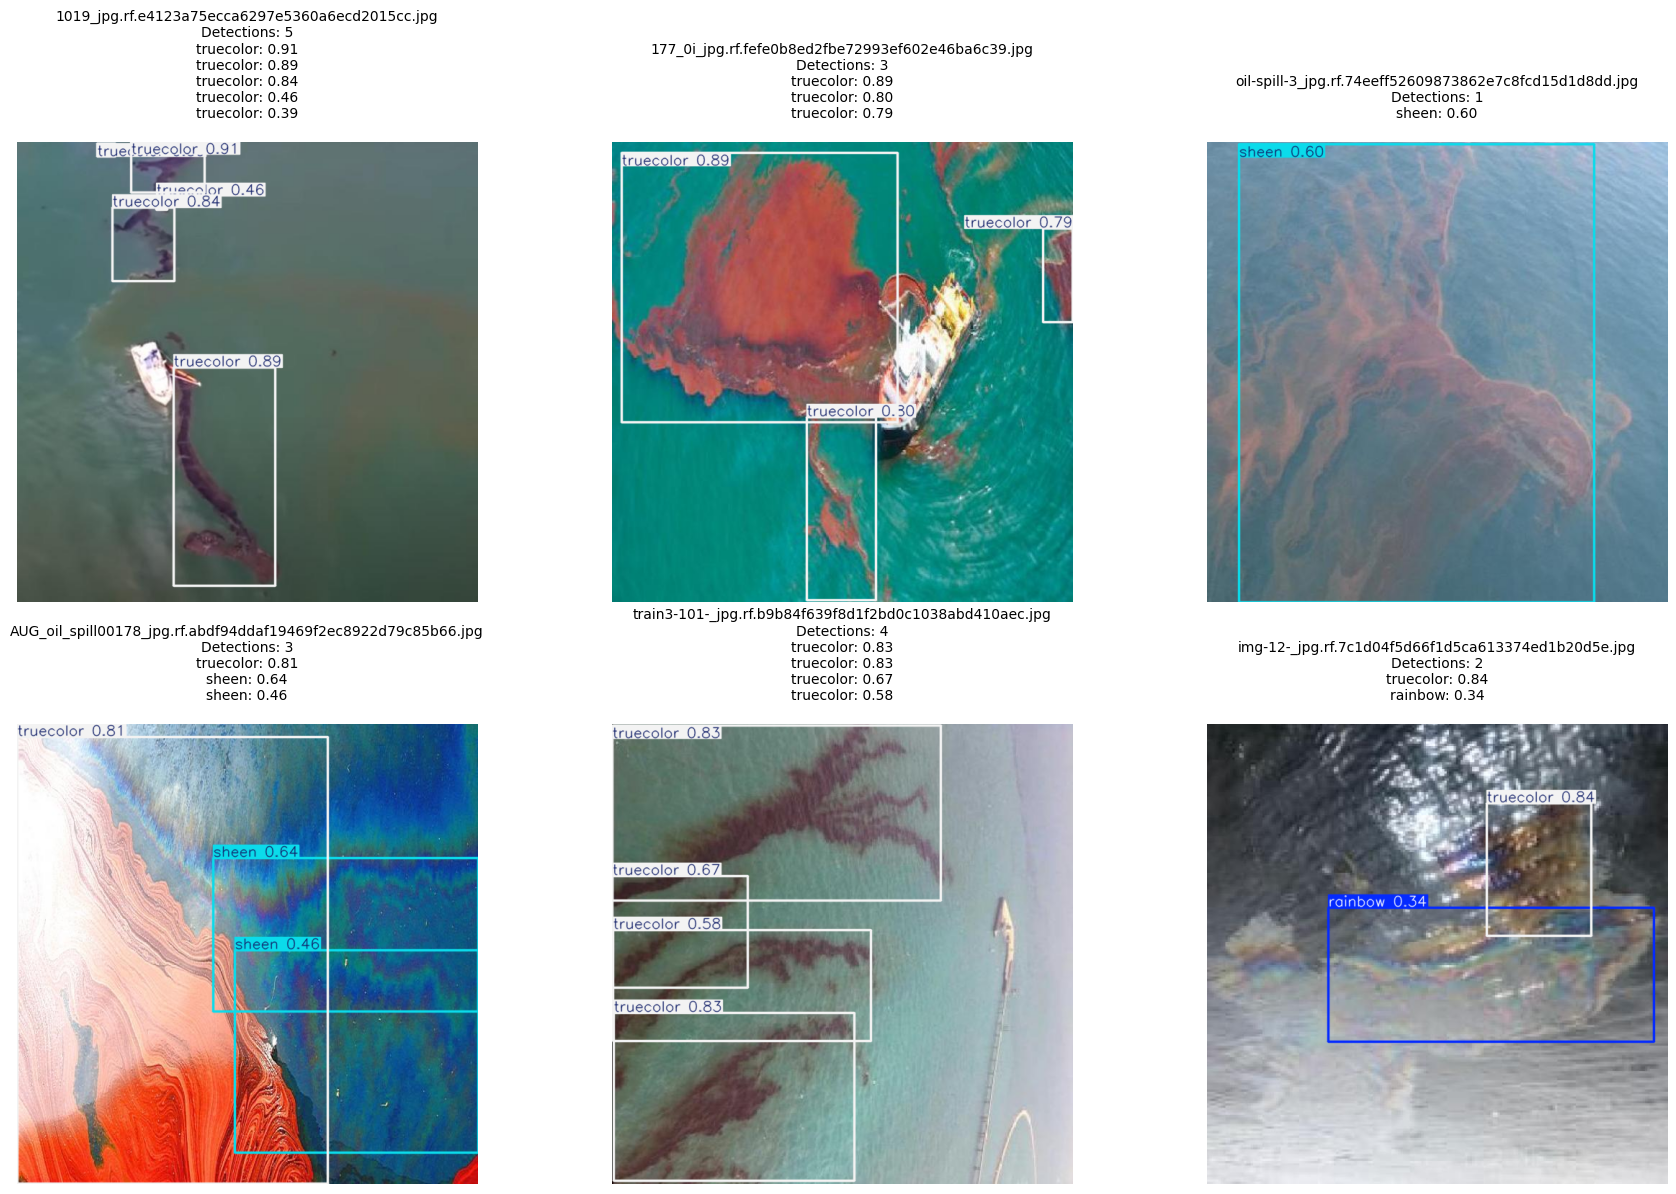

In [32]:
def visualize_test_results(num_samples=6):
    """Visualize sample test results"""

    print(f"🎨 Visualizing {num_samples} sample results...")

    # Get test images and their results
    test_images = glob.glob('/content/drive/MyDrive/data/test/images/*.jpg')[:num_samples]

    # Run predictions on samples
    results = model.predict(test_images, conf=0.25, save=False)

    # Create visualization grid
    cols = 3
    rows = (len(test_images) + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(18, 6*rows))
    if rows == 1:
        axes = axes.reshape(1, -1)

    class_names = ['rainbow', 'sheen', 'truecolor']

    for i, (img_path, result) in enumerate(zip(test_images, results)):
        row, col = i // cols, i % cols

        if result.boxes is not None and len(result.boxes) > 0:
            # Draw detections
            detected_img = result.plot(conf=True, labels=True, boxes=True)
            axes[row, col].imshow(cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB))

            # Count detections by class
            detections_text = f"Detections: {len(result.boxes)}\n"
            for box in result.boxes:
                class_id = int(box.cls.item())
                conf = box.conf.item()
                detections_text += f"{class_names[class_id]}: {conf:.2f}\n"

            axes[row, col].set_title(f"{os.path.basename(img_path)}\n{detections_text}",
                                   fontsize=10)
        else:
            # No detections
            axes[row, col].imshow(cv2.cvtColor(result.orig_img, cv2.COLOR_BGR2RGB))
            axes[row, col].set_title(f"{os.path.basename(img_path)}\nNo detections",
                                   fontsize=10)

        axes[row, col].axis('off')

    # Hide empty subplots
    for i in range(len(test_images), rows * cols):
        row, col = i // cols, i % cols
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize samples
visualize_test_results()

🧪 Testing on uploaded image: oil_2.jpg

🛢️ DETECTION RESULTS:
Detection 1:
  • Type: truecolor
  • Confidence: 0.701 (70.1%)
  • Location: (246, 5) to (643, 360)
  • Size: 60.89% of image



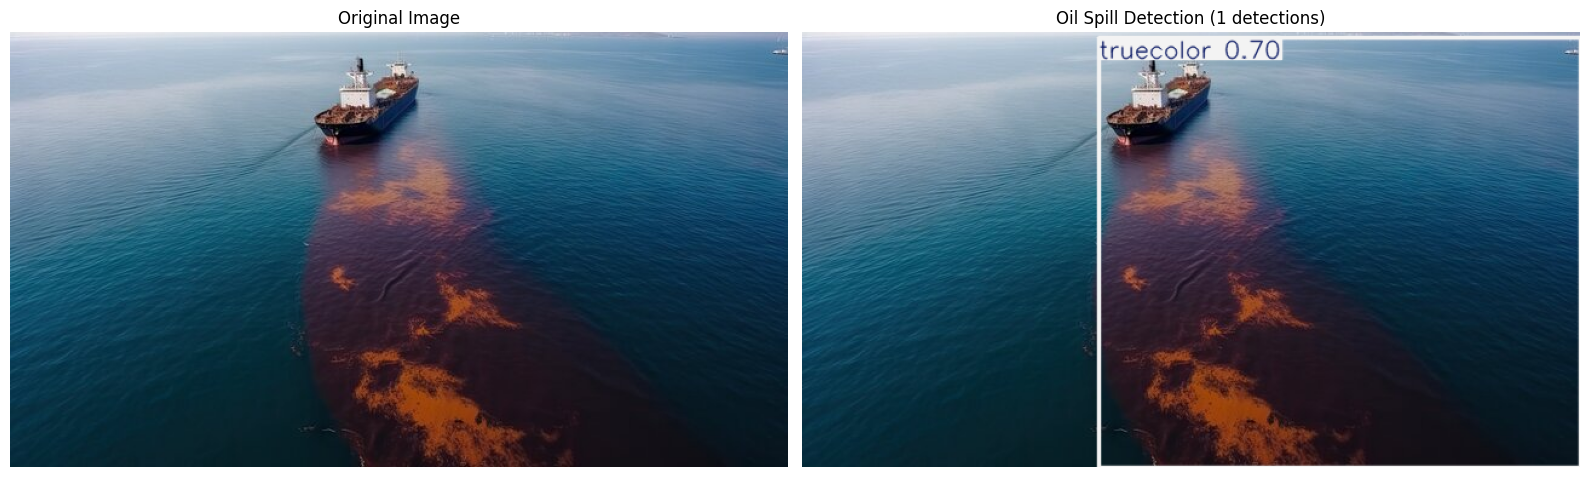

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'rainbow', 1: 'sheen', 2: 'truecolor'}
 obb: None
 orig_img: array([[[235, 232, 228],
         [234, 231, 227],
         [233, 230, 226],
         ...,
         [189, 164, 154],
         [189, 164, 154],
         [189, 164, 154]],
 
        [[232, 229, 225],
         [231, 228, 224],
         [230, 227, 223],
         ...,
         [188, 163, 153],
         [188, 163, 153],
         [190, 163, 153]],
 
        [[232, 227, 224],
         [231, 226, 223],
         [231, 226, 223],
         ...,
         [187, 160, 150],
         [187, 160, 150],
         [188, 159, 150]],
 
        ...,
 
        [[ 57,  42,   3],
         [ 57,  42,   3],
         [ 56,  41,   2],
         ...,
         [ 29,  20,   6],
         [ 29,  20,   6],
         [ 29,  20,   6]],
 
        [[ 54,  41,   3],
         [ 54,  41,   3],
         [ 53,  40,   2],
   

In [ ]:
def test_uploaded_image(image_path, conf_threshold=0.15):
    """Test model on a specific uploaded image"""

    print(f"🧪 Testing on uploaded image: {image_path}")

    # Check if image exists
    if not os.path.exists(image_path):
        print(f"❌ Image not found: {image_path}")
        return

    # Run prediction
    results = model.predict(
        source=image_path,
        conf=conf_threshold,
        save=False,
        verbose=False
    )

    result = results[0]

    # Create side-by-side visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Original image
    original_img = cv2.cvtColor(result.orig_img, cv2.COLOR_BGR2RGB)
    ax1.imshow(original_img)
    ax1.set_title("Original Image")
    ax1.axis('off')

    # Detected image
    if result.boxes is not None and len(result.boxes) > 0:
        detected_img = result.plot(conf=True, labels=True, boxes=True)
        ax2.imshow(cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB))
        ax2.set_title(f"Oil Spill Detection ({len(result.boxes)} detections)")

        # Print detailed results
        class_names = ['rainbow', 'sheen', 'truecolor']
        print(f"\n🛢️ DETECTION RESULTS:")
        print("=" * 30)

        for i, box in enumerate(result.boxes):
            class_id = int(box.cls.item())
            conf = box.conf.item()
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()

            # Calculate area
            area = (x2 - x1) * (y2 - y1)
            img_area = original_img.shape[0] * original_img.shape[1]
            area_percentage = (area / img_area) * 100

            print(f"Detection {i+1}:")
            print(f"  • Type: {class_names[class_id]}")
            print(f"  • Confidence: {conf:.3f} ({conf:.1%})")
            print(f"  • Location: ({x1:.0f}, {y1:.0f}) to ({x2:.0f}, {y2:.0f})")
            print(f"  • Size: {area_percentage:.2f}% of image")
            print()

    else:
        ax2.imshow(original_img)
        ax2.set_title("No Oil Spills Detected")
        print("❌ No oil spills detected in this image")

    ax2.axis('off')
    plt.tight_layout()
    plt.show()

    return results


test_uploaded_image("oil_2.jpg")